Loading transitions file: only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv
Loaded 109 subjects (ALL subjects, no filter)
Total columns: 20

Filtering by final cluster state (after == 0)...
Subjects before filtering: 109
Subjects after filtering: 76
Removed: 33 subjects

Total subjects: 76
Columns: ['Subject_Code', 'b', 't1', 't2', 't3', 'after']

Creating trajectory heatmap for subjects with after == 0...

Transition Analysis:
b→t1: 20 changes (26.3% of subjects) <-- MOST CHANGES
t1→t2: 14 changes (18.4% of subjects)
t2→t3: 14 changes (18.4% of subjects)
t3→after: 12 changes (15.8% of subjects)


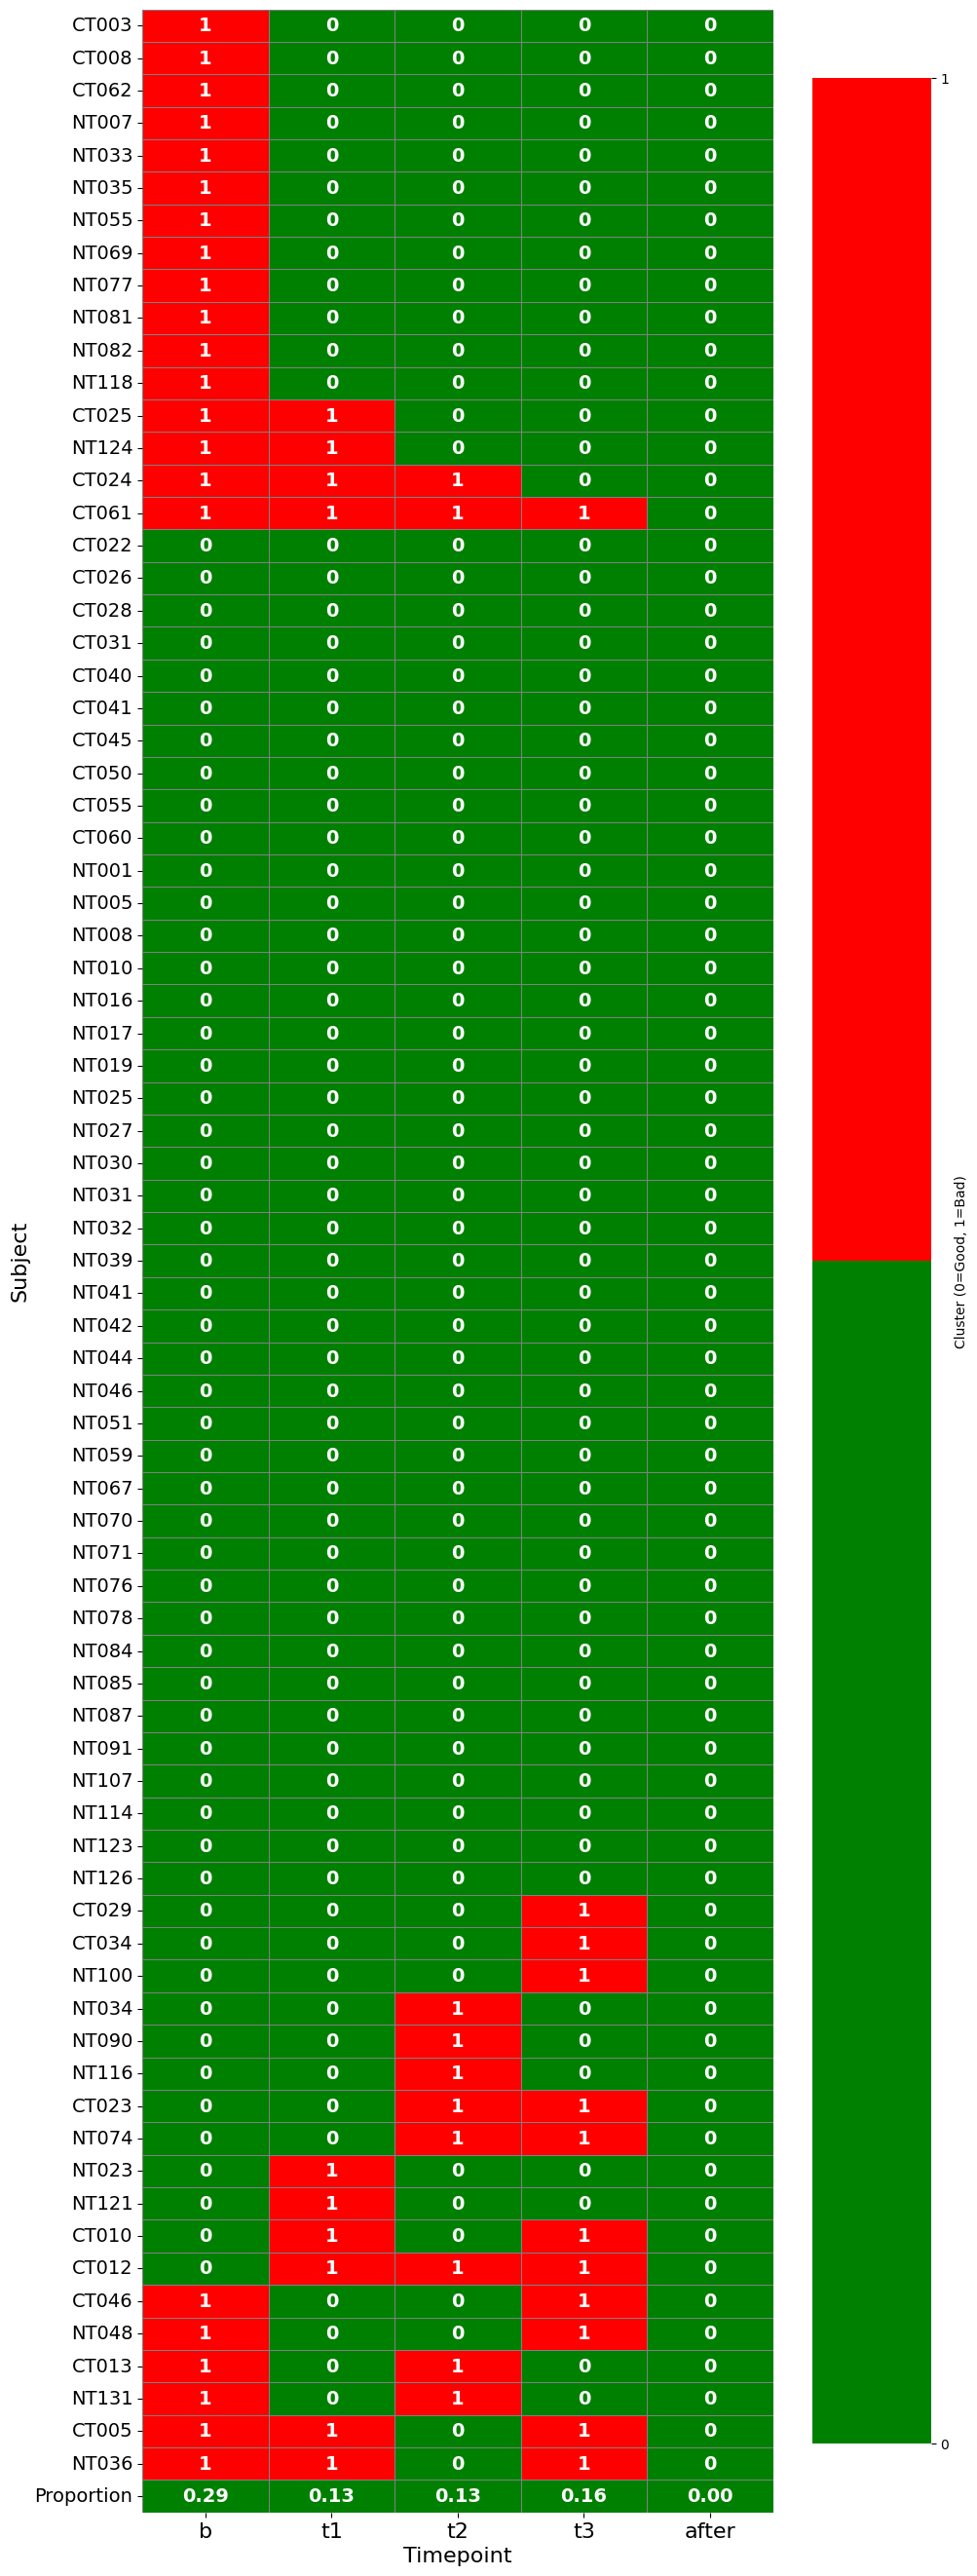

NameError: name 'assign_group' is not defined

In [5]:
import pandas as pd
import os

# ----------------  
# Load ALL subjects (not just after == 1)
# ----------------
# Input file (transitions file with all timepoints)
transitions_file_path = r"only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv"

# Column names
subject_col = "Subject_Code"  # Subject code column name
timepoint_cols = ["b", "t1", "t2", "t3", "after"]  # Timepoint cluster columns

# Filter option: Set to filter by final cluster state
# Options: None (show all), 0 (only cluster 0), 1 (only cluster 1)
filter_by_after = 0  # Change to 0 or 1 to filter, or None to show all

# Load transitions file
print(f"Loading transitions file: {transitions_file_path}")
df_all = pd.read_csv(transitions_file_path)

print(f"Loaded {len(df_all)} subjects (ALL subjects, no filter)")
print(f"Total columns: {len(df_all.columns)}")

# Check which timepoint columns exist
existing_timepoint_cols = [col for col in timepoint_cols if col in df_all.columns]
missing_timepoint_cols = [col for col in timepoint_cols if col not in df_all.columns]

if missing_timepoint_cols:
    print(f"Warning: These timepoint columns not found: {missing_timepoint_cols}")

if not existing_timepoint_cols:
    raise ValueError(f"None of the timepoint columns {timepoint_cols} found in file.")

# Convert columns to numeric
df_all[subject_col] = df_all[subject_col].astype(str)
for col in existing_timepoint_cols:
    df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

# Select only subject code and timepoint columns
output_df = df_all[[subject_col] + existing_timepoint_cols].copy()

# Apply filter by final cluster state if requested
if filter_by_after is not None:
    if 'after' not in output_df.columns:
        raise ValueError("'after' column not found. Cannot filter by final cluster state.")
    n_before = len(output_df)
    output_df = output_df[output_df['after'] == filter_by_after].copy()
    n_after = len(output_df)
    print(f"\nFiltering by final cluster state (after == {filter_by_after})...")
    print(f"Subjects before filtering: {n_before}")
    print(f"Subjects after filtering: {n_after}")
    print(f"Removed: {n_before - n_after} subjects")
else:
    print(f"\nShowing ALL subjects (no filter)")

# Sort by subject code
output_df = output_df.sort_values(by=subject_col).reset_index(drop=True)

print(f"\nTotal subjects: {len(output_df)}")
print(f"Columns: {list(output_df.columns)}")

# Now run the visualization code with ALL subjects
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

# ----------------
# Heatmap Visualization: Trajectory of subjects between clusters
# ----------------
filter_label = f"subjects with after == {filter_by_after}" if filter_by_after is not None else "ALL subjects"
print(f"\n{'='*70}")
print(f"Creating trajectory heatmap for {filter_label}...")
print(f"{'='*70}")

# Prepare data for plotting
timepoint_labels = ["b", "t1", "t2", "t3", "after"]
transition_labels = ["b→t1", "t1→t2", "t2→t3", "t3→after"]

# Create trajectory pattern string for sorting
def create_trajectory_pattern(row, timepoint_cols):
    """Create a string representation of the trajectory for sorting"""
    return '-'.join([str(int(row[col])) if not pd.isna(row[col]) else 'N' 
                     for col in timepoint_cols])

output_df['trajectory_pattern'] = output_df.apply(
    lambda row: create_trajectory_pattern(row, timepoint_labels), axis=1
)

# Count cluster changes for sorting
def count_cluster_changes(row, timepoint_cols):
    """Count the number of times cluster changes between consecutive timepoints"""
    changes = 0
    values = [row[col] for col in timepoint_cols]
    for i in range(len(values) - 1):
        if not (pd.isna(values[i]) or pd.isna(values[i+1])):
            if values[i] != values[i+1]:
                changes += 1
    return changes

output_df['n_changes'] = output_df.apply(
    lambda row: count_cluster_changes(row, timepoint_labels), axis=1
)

# Find which transition has the most changes
def get_transition_changes(row, timepoint_cols):
    """Get list of which transitions have changes (1 if change, 0 if no change)"""
    changes = []
    values = [row[col] for col in timepoint_cols]
    for i in range(len(values) - 1):
        if not (pd.isna(values[i]) or pd.isna(values[i+1])):
            changes.append(1 if values[i] != values[i+1] else 0)
        else:
            changes.append(0)
    return changes

# Add columns for each transition
for i, trans_label in enumerate(transition_labels):
    output_df[f'change_{i}'] = output_df.apply(
        lambda row: get_transition_changes(row, timepoint_labels)[i], axis=1
    )

# Calculate number of changes at each transition point
transition_counts = []
for i in range(len(transition_labels)):
    count = output_df[f'change_{i}'].sum()
    transition_counts.append(count)

# Find which transition has the most changes
max_transition_idx = np.argmax(transition_counts)
max_transition = transition_labels[max_transition_idx]
max_count = transition_counts[max_transition_idx]

print(f"\nTransition Analysis:")
print(f"{'='*70}")
for i, (trans, count) in enumerate(zip(transition_labels, transition_counts)):
    marker = " <-- MOST CHANGES" if i == max_transition_idx else ""
    print(f"{trans}: {count} changes ({count/len(output_df)*100:.1f}% of subjects){marker}")

# Sort subjects to better visualize transitions:
# 1. First by number of changes (prioritize 1 change at the top)
# 2. Then by starting cluster (b)
# 3. Then by trajectory pattern (to group similar trajectories)
# Create a custom sort key: 1 change first, then others
output_df['sort_key'] = output_df['n_changes'].apply(lambda x: 0 if x == 1 else 1)
output_df_sorted = output_df.sort_values(
    by=['sort_key', 'b', 'trajectory_pattern', 'n_changes', subject_col]
).reset_index(drop=True)

# Calculate proportions for each timepoint
proportions = []
for col in timepoint_labels:
    prop = output_df[col].mean()
    proportions.append(prop)

# Prepare data for heatmap
heatmap_data = output_df_sorted[timepoint_labels].values

# Add proportions row at the bottom
proportions_row = np.array([proportions])
heatmap_data_with_props = np.vstack([heatmap_data, proportions_row])

# Create labels (subjects + "Proportion" row)
subject_labels = list(output_df_sorted[subject_col].values) + ['Proportion']
subject_labels_array = np.array(subject_labels)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, max(10, len(output_df) * 0.35)))

# Create custom colormap: green for 0, red for 1
colors = ['green', 'red']  # 0 = green (good), 1 = red (bad)
n_bins = 2
cmap = ListedColormap(colors)

# Create annotation array - show integer values for subjects, proportions for last row
annot_data = []
for i in range(len(heatmap_data_with_props)):
    if i < len(output_df):
        # Subject rows: show integers (0 or 1)
        annot_data.append([f'{int(val)}' for val in heatmap_data_with_props[i]])
    else:
        # Proportion row: show 2 decimal places
        annot_data.append([f'{val:.2f}' for val in heatmap_data_with_props[i]])
annot_data = np.array(annot_data)

# Create heatmap
heatmap_obj = sns.heatmap(heatmap_data_with_props, 
            annot=annot_data,  # Show formatted values
            fmt='',            # Empty fmt since we're providing formatted strings
            cmap=cmap,         # Custom colormap: green=0/good, red=1/bad
            vmin=0, vmax=1,
            cbar_kws={'label': 'Cluster (0=Good, 1=Bad)', 'ticks': [0, 1]},
            yticklabels=subject_labels_array,
            xticklabels=timepoint_labels,
            linewidths=0.5,
            linecolor='gray',
            ax=ax,
            annot_kws={'size': 14, 'weight': 'bold'})  # Bigger, bold font for annotations

# Recolor the proportions row to light blue
proportions_row_idx = len(output_df)  # Index of proportions row (0-based)
quadmesh = heatmap_obj.collections[0]
face_colors = quadmesh.get_facecolors()
n_cols = len(timepoint_labels)
start_idx = proportions_row_idx * n_cols
end_idx = start_idx + n_cols
lightblue = [0.68, 0.85, 1.0, 1.0]
for idx in range(start_idx, min(end_idx, len(face_colors))):
    face_colors[idx] = lightblue
quadmesh.set_facecolors(face_colors)

ax.set_ylabel('Subject', fontsize=16)
ax.set_xlabel('Timepoint', fontsize=16)

# Rotate y-axis labels for better readability
plt.yticks(rotation=0, fontsize=14)
plt.xticks(rotation=0, fontsize=16)

plt.tight_layout()
plt.show()

# ----------------
# Calculate and display group counts
# ----------------


output_df['n_changes'] = output_df.apply(
    lambda row: count_cluster_changes(row, timepoint_labels), axis=1
)

# Group subjects by number of changes
change_groups = {
    0: '0 changes (stable)',
    1: '1 change',
    2: '2 changes',
    3: '3+ changes'
}



output_df['change_group'] = output_df['n_changes'].apply(assign_group)

# ----------------
# Display group counts
# ----------------
print(f"\n{'='*70}")
print(f"Group Distribution by Number of Cluster Changes ({filter_label.upper()})")
print(f"{'='*70}")

group_counts = output_df['change_group'].value_counts()
# Reorder to match the group order
ordered_groups = [change_groups[0], change_groups[1], change_groups[2], change_groups[3]]
group_counts_ordered = group_counts.reindex([g for g in ordered_groups if g in group_counts.index], fill_value=0)
group_percentages = (group_counts_ordered / len(output_df) * 100).round(1)

summary_df = pd.DataFrame({
    'Group': group_counts_ordered.index,
    'Count': group_counts_ordered.values,
    'Percentage': group_percentages.values
})

print("\n" + summary_df.to_string(index=False))
print(f"\nTotal subjects: {len(output_df)}")

# Show some examples from each group
print(f"\n{'='*70}")
print("Example subjects from each group:")
print(f"{'='*70}")

for group_name in ordered_groups:
    group_subjects = output_df[output_df['change_group'] == group_name]
    if len(group_subjects) > 0:
        print(f"\n{group_name} (n={len(group_subjects)}):")
        # Show first 3 subjects from this group
        examples = group_subjects.head(3)
        for idx, row in examples.iterrows():
            trajectory_str = ' -> '.join([f"{row[col]:.0f}" for col in timepoint_labels])
            print(f"  {row[subject_col]}: {trajectory_str} (changes: {row['n_changes']})")


Subjects ending in cluster 1: 33
Subjects ending in cluster 0: 76


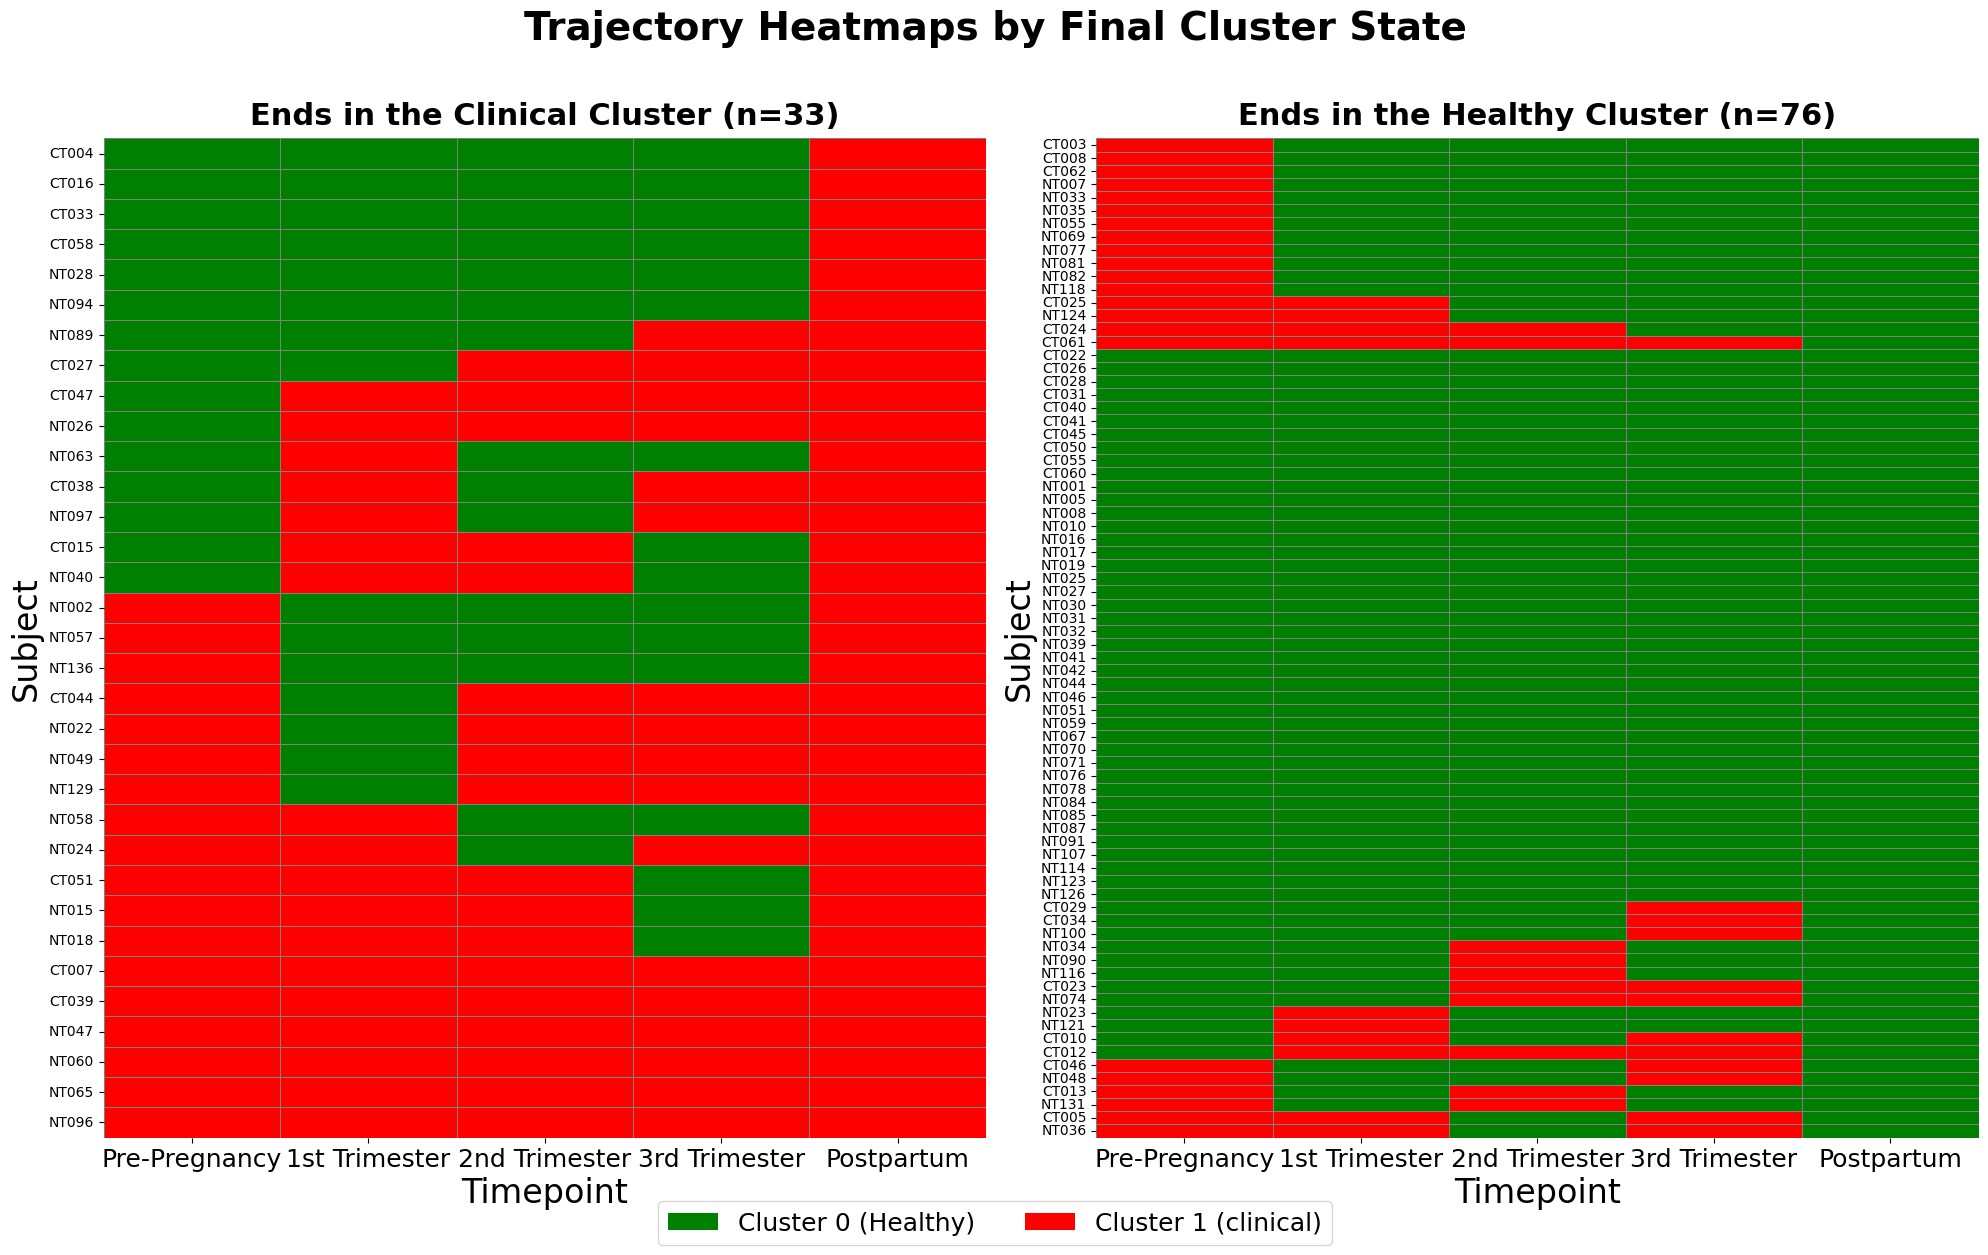


Figure saved with dimensions: 20 x 12 inches
Left plot: 33 subjects ending in cluster 1
Right plot: 76 subjects ending in cluster 0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# ----------------  
# Load data
# ----------------
transitions_file_path = r"only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv"
subject_col = "Subject_Code"
timepoint_cols = ["b", "t1", "t2", "t3", "after"]

# Load transitions file
df_all = pd.read_csv(transitions_file_path)

# Check which timepoint columns exist
existing_timepoint_cols = [col for col in timepoint_cols if col in df_all.columns]
if not existing_timepoint_cols:
    raise ValueError(f"None of the timepoint columns {timepoint_cols} found in file.")

# Convert columns to numeric
df_all[subject_col] = df_all[subject_col].astype(str)
for col in existing_timepoint_cols:
    df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

# Prepare base dataframe
base_df = df_all[[subject_col] + existing_timepoint_cols].copy()

# Figure size parameters
figure_width = 20  # Total width for both plots
row_height = 0.2   # Height per subject row
max_height = 12    # Maximum height

# Prepare data for plotting
timepoint_labels = ["b", "t1", "t2", "t3", "after"]  # Column names in data
transition_labels = ["b→t1", "t1→t2", "t2→t3", "t3→after"]

# Customize x-axis tick labels (display names on the heatmap)
# Set to None to use the same as timepoint_labels, or provide custom labels
# Example: ["Baseline", "Time 1", "Time 2", "Time 3", "Follow-up"]
x_tick_labels = ["Pre-Pregnancy", "1st Trimester", "2nd Trimester", "3rd Trimester", "Postpartum"]  # Change to custom list like ["Baseline", "T1", "T2", "T3", "After"] or None to use timepoint_labels

# If x_tick_labels is None, use timepoint_labels
if x_tick_labels is None:
    x_tick_labels = timepoint_labels
elif len(x_tick_labels) != len(timepoint_labels):
    print(f"Warning: x_tick_labels length ({len(x_tick_labels)}) doesn't match timepoint_labels length ({len(timepoint_labels)})")
    print(f"Using timepoint_labels instead")
    x_tick_labels = timepoint_labels

# Helper functions
def create_trajectory_pattern(row, timepoint_cols):
    return '-'.join([str(int(row[col])) if not pd.isna(row[col]) else 'N' 
                     for col in timepoint_cols])

def count_cluster_changes(row, timepoint_cols):
    changes = 0
    values = [row[col] for col in timepoint_cols]
    for i in range(len(values) - 1):
        if not (pd.isna(values[i]) or pd.isna(values[i+1])):
            if values[i] != values[i+1]:
                changes += 1
    return changes

def prepare_heatmap_data(df_filtered, timepoint_labels, subject_col):
    """Prepare data for heatmap visualization"""
    df = df_filtered.copy()
    
    # Calculate trajectory metrics
    df['trajectory_pattern'] = df.apply(
        lambda row: create_trajectory_pattern(row, timepoint_labels), axis=1
    )
    df['n_changes'] = df.apply(
        lambda row: count_cluster_changes(row, timepoint_labels), axis=1
    )
    
    # Sort subjects
    df['sort_key'] = df['n_changes'].apply(lambda x: 0 if x == 1 else 1)
    df_sorted = df.sort_values(
        by=['sort_key', 'b', 'trajectory_pattern', 'n_changes', subject_col]
    ).reset_index(drop=True)
    
    # Prepare heatmap data (without proportions row)
    heatmap_data = df_sorted[timepoint_labels].values
    
    # Create labels (without Proportion)
    subject_labels = list(df_sorted[subject_col].values)
    
    return heatmap_data, subject_labels, df_sorted

# Filter data for each group
df_after_1 = base_df[base_df['after'] == 1].copy().reset_index(drop=True)
df_after_0 = base_df[base_df['after'] == 0].copy().reset_index(drop=True)

print(f"Subjects ending in cluster 1: {len(df_after_1)}")
print(f"Subjects ending in cluster 0: {len(df_after_0)}")

# Prepare data for both heatmaps
data_1, labels_1, df_sorted_1 = prepare_heatmap_data(df_after_1, timepoint_labels, subject_col)
data_0, labels_0, df_sorted_0 = prepare_heatmap_data(df_after_0, timepoint_labels, subject_col)

# Calculate figure height based on the larger group
max_subjects = max(len(df_after_1), len(df_after_0))
figure_height = min(max_height, max(6, max_subjects * row_height))

# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figure_width, figure_height))
fig.suptitle('Trajectory Heatmaps by Final Cluster State', fontsize=28, fontweight='bold', y=1.02)

# Custom colormap
colors = ['green', 'red']
cmap = ListedColormap(colors)

# Create annotation arrays - set to None to remove annotations, or use smaller font
# Option: Set show_annotations = False to remove all text, or True to show with smaller font
show_annotations = False  # Set to True if you want annotations (will be smaller)

if show_annotations:
    def create_annotations(heatmap_data, n_subjects):
        annot_data = []
        for i in range(len(heatmap_data)):
            annot_data.append([f'{int(val)}' for val in heatmap_data[i]])
        return np.array(annot_data)
    annot_1 = create_annotations(data_1, len(df_after_1))
    annot_0 = create_annotations(data_0, len(df_after_0))
else:
    annot_1 = None
    annot_0 = None

# LEFT PLOT: Cluster 1 (after == 1)
heatmap_obj_1 = sns.heatmap(data_1, 
            annot=annot_1,
            fmt='' if annot_1 is not None else '',
            cmap=cmap,
            vmin=0, vmax=1,
            cbar=False,  # Remove colorbar, we'll add legend instead
            yticklabels=labels_1,
            xticklabels=x_tick_labels,
            linewidths=0.5,
            linecolor='gray',
            ax=ax1,
            annot_kws={'size': 12, 'weight': 'bold'} if annot_1 is not None else {})

# No proportions row to recolor

ax1.set_ylabel('Subject', fontsize=24)
ax1.set_xlabel('Timepoint', fontsize=24)
ax1.set_title('Ends in the Clinical Cluster (n={})'.format(len(df_after_1)), fontsize=22, fontweight='bold', pad=10)
# Make y-axis labels less dense - show every nth label
n_skip_1 = max(1, len(df_after_1) // 30)  # Show approximately 30 labels max
y_tick_positions_1 = ax1.get_yticks()
y_tick_labels_1 = [labels_1[int(i)] if i < len(labels_1) else '' for i in y_tick_positions_1]
# Only show every nth label
for i in range(len(y_tick_labels_1)):
    if i % n_skip_1 != 0:
        y_tick_labels_1[i] = ''
ax1.set_yticklabels(y_tick_labels_1, fontsize=10)
plt.setp(ax1.get_xticklabels(), fontsize=18)

# RIGHT PLOT: Cluster 0 (after == 0)
heatmap_obj_0 = sns.heatmap(data_0, 
            annot=annot_0,
            fmt='' if annot_0 is not None else '',
            cmap=cmap,
            vmin=0, vmax=1,
            cbar=False,  # Remove colorbar, we'll add legend instead
            yticklabels=labels_0,
            xticklabels=x_tick_labels,
            linewidths=0.5,
            linecolor='gray',
            ax=ax2,
            annot_kws={'size': 12, 'weight': 'bold'} if annot_0 is not None else {})

# No proportions row to recolor

ax2.set_ylabel('Subject', fontsize=24)
ax2.set_xlabel('Timepoint', fontsize=24)
ax2.set_title('Ends in the Healthy Cluster (n={})'.format(len(df_after_0)), fontsize=22, fontweight='bold', pad=10)
# Show all subject names on the right plot (no thinning)
ax2.set_yticklabels(labels_0, fontsize=10)
plt.setp(ax2.get_xticklabels(), fontsize=18)

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Cluster 0 (Healthy)'),
    Patch(facecolor='red', label='Cluster 1 (clinical)')
]
# Add legend to the figure (centered at bottom)
fig.legend(handles=legend_elements, loc='lower center', ncol=2, fontsize=18, frameon=True, 
           bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)  # Make room for legend
plt.show()

print(f"\nFigure saved with dimensions: {figure_width} x {figure_height} inches")
print(f"Left plot: {len(df_after_1)} subjects ending in cluster 1")
print(f"Right plot: {len(df_after_0)} subjects ending in cluster 0")



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

path = r"only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv"
df = pd.read_csv(path)

df["after"] = pd.to_numeric(df["after"], errors="coerce")
df2 = df[df["after"].isin([0, 1])].copy()

transition_cols = ["B_TO_T1", "T1_TO_T2", "T2_TO_T3", "T3_TO_AFTER"]

for col in transition_cols:
    # counts
    counts = pd.crosstab(df2[col], df2["after"]).reindex(columns=[0, 1], fill_value=0)
    counts.columns = ["after_0_n", "after_1_n"]
    counts["n_total"] = counts["after_0_n"] + counts["after_1_n"]

    # percentages
    pct = counts[["after_0_n", "after_1_n"]].div(counts["n_total"], axis=0) * 100
    pct.columns = ["after_0_%", "after_1_%"]

    # combined table
    summary = pd.concat([counts, pct], axis=1)
    summary = summary[["after_0_n", "after_0_%", "after_1_n", "after_1_%", "n_total"]]

    print(f"\n=== {col} (COUNTS + PERCENT) ===")
    print(summary.round({"after_0_%": 1, "after_1_%": 1}))

    # plot percentages
    ax = pct.plot(kind="bar", stacked=True)
    ax.set_title(f"After (0/1) distribution by {col} (percent)")
    ax.set_xlabel(col)
    ax.set_ylabel("Percent of subjects")
    plt.xticks(rotation=45, ha="right")

    # annotate percentages inside bars
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height <= 0:
                continue
            if height < 5:  # optional
                continue
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + height / 2
            ax.text(x, y, f"{height:.1f}%", ha="center", va="center", fontsize=9)

    # annotate n above each bar
    group_n = counts["n_total"]
    for i, n in enumerate(group_n.values):
        ax.text(i, 102, f"n={int(n)}", ha="center", va="bottom", fontsize=10)

    ax.set_ylim(0, 110)
    plt.tight_layout()
    plt.show()
